In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from m0b_optimizer import MyOptimizer
import math
from datetime import datetime
from microsoft_custom_linear_regressor import MicrosoftCustomLinearRegressor
from mpl_toolkits import mplot3d
import statsmodels.formula.api as smf





In [2]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/m0b_optimizer.py

--2024-12-17 11:17:15--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/m0b_optimizer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1287 (1,3K) [text/plain]
Saving to: 'm0b_optimizer.py.5'

     0K .                                                     100% 90,9M=0s

2024-12-17 11:17:15 (90,9 MB/s) - 'm0b_optimizer.py.5' saved [1287/1287]



In [3]:
url = "https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv"
response = requests.get(url)

with open("seattleWeather_1948-2017.csv", "wb") as f:
    f.write(response.content)
    
data = pd.read_csv('seattleWeather_1948-2017.csv', parse_dates=['date'])

# Keep only January temperatures
data = data[[d.month == 1 for d in data.date]].copy()

data

,date,amount_of_precipitation,max_temperature,min_temperature,rain
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True
...,...,...,...,...,...
25229,2017-01-27,0.00,54,37,False
25230,2017-01-28,0.00,52,37,False
25231,2017-01-29,0.03,48,37,True
25232,2017-01-30,0.02,45,40,True


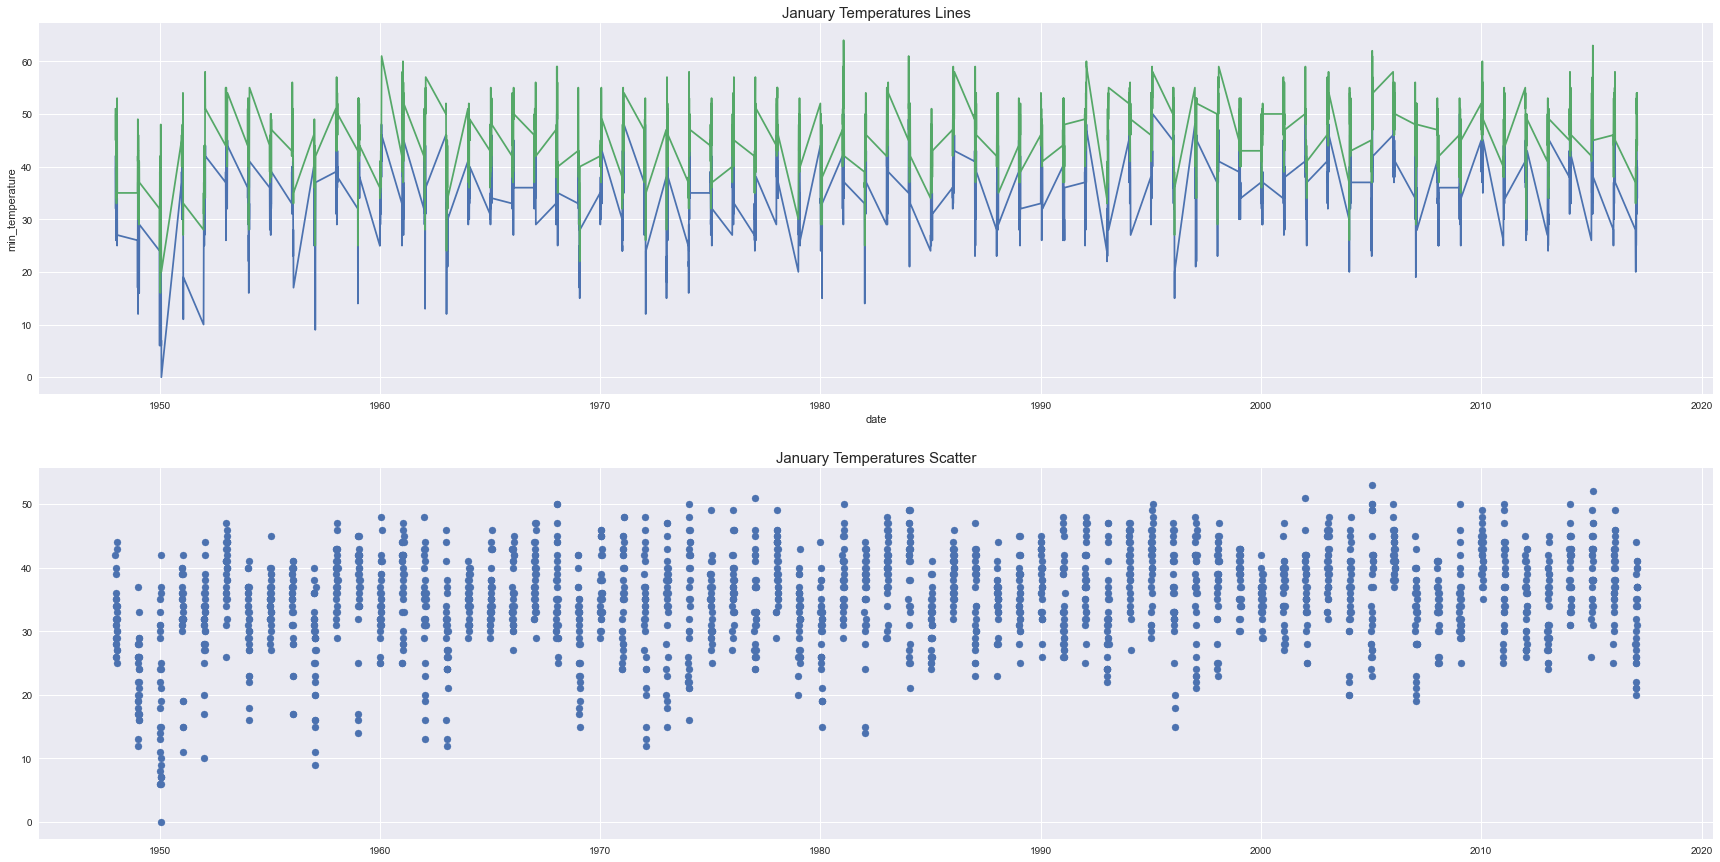

In [4]:
plt.style.use('seaborn')
fig, axs = plt.subplot_mosaic([
                                ['1'],
                                ['2'],
                                ],      
                                figsize=(30, 15))
axs["1"].set_title("January Temperatures Lines", size=15)
sns.lineplot(data=data, x=data["date"], y=data["min_temperature"], ax=axs['1'])
sns.lineplot(data=data, x=data["date"], y=data["max_temperature"], ax=axs['1'])

axs["2"].set_title("January Temperatures Scatter", size=15)
axs["2"].scatter(data["date"], data["min_temperature"])

## Scaling

In [5]:
# Offset date into number of years since 1982
data["years_since_1982"] = [(d.year + d.timetuple().tm_yday / 365.25) - 1982 for d in data.date]

# Scale and offset temperature so that it has a smaller range of values
data["normalised_temperature"] = (data["min_temperature"] - np.mean(data["min_temperature"])) / np.std(data["min_temperature"])


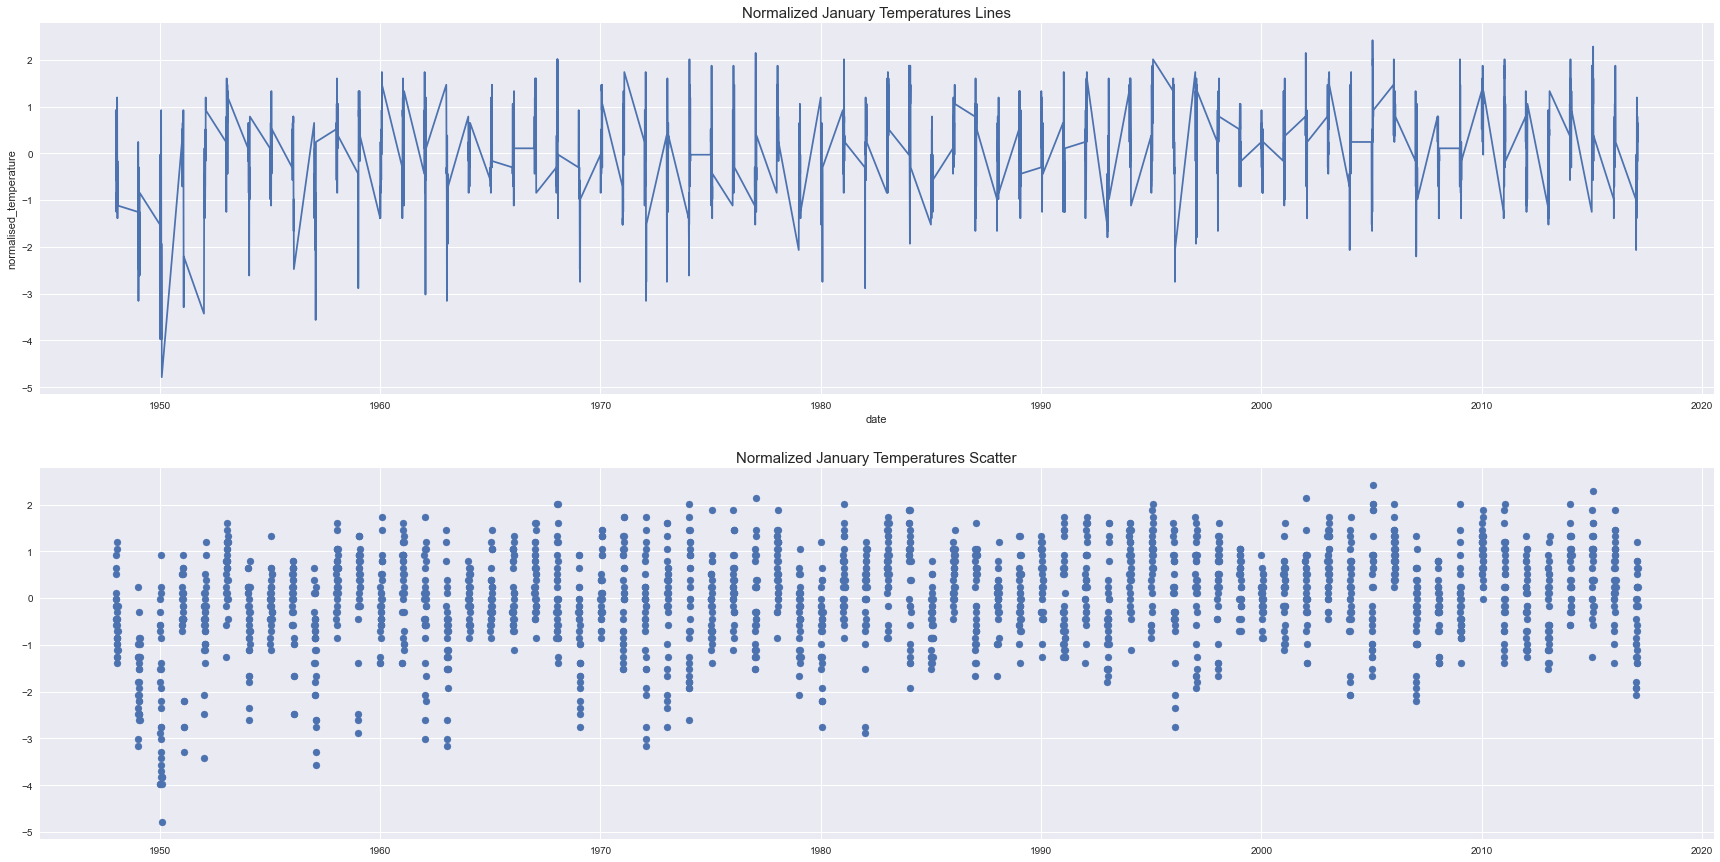

In [6]:
plt.style.use('seaborn')
fig, axs = plt.subplot_mosaic([
                                ['1'],
                                ['2'],
                                ],      
                                figsize=(30, 15))
axs["1"].set_title("Normalized January Temperatures Lines", size=15)
sns.lineplot(data=data, x=data["date"], y=data["normalised_temperature"], ax=axs['1'])

axs["2"].set_title("Normalized January Temperatures Scatter", size=15)
axs["2"].scatter(data["date"], data["normalised_temperature"])

## Model

In [7]:
class MyModel:

    def __init__(self):
        self.slope = 0
        self.intercept = 0
    
    def predict(self, date):

        return date * self.slope + self.intercept

model = MyModel()

Model parameters before training: 0, 0


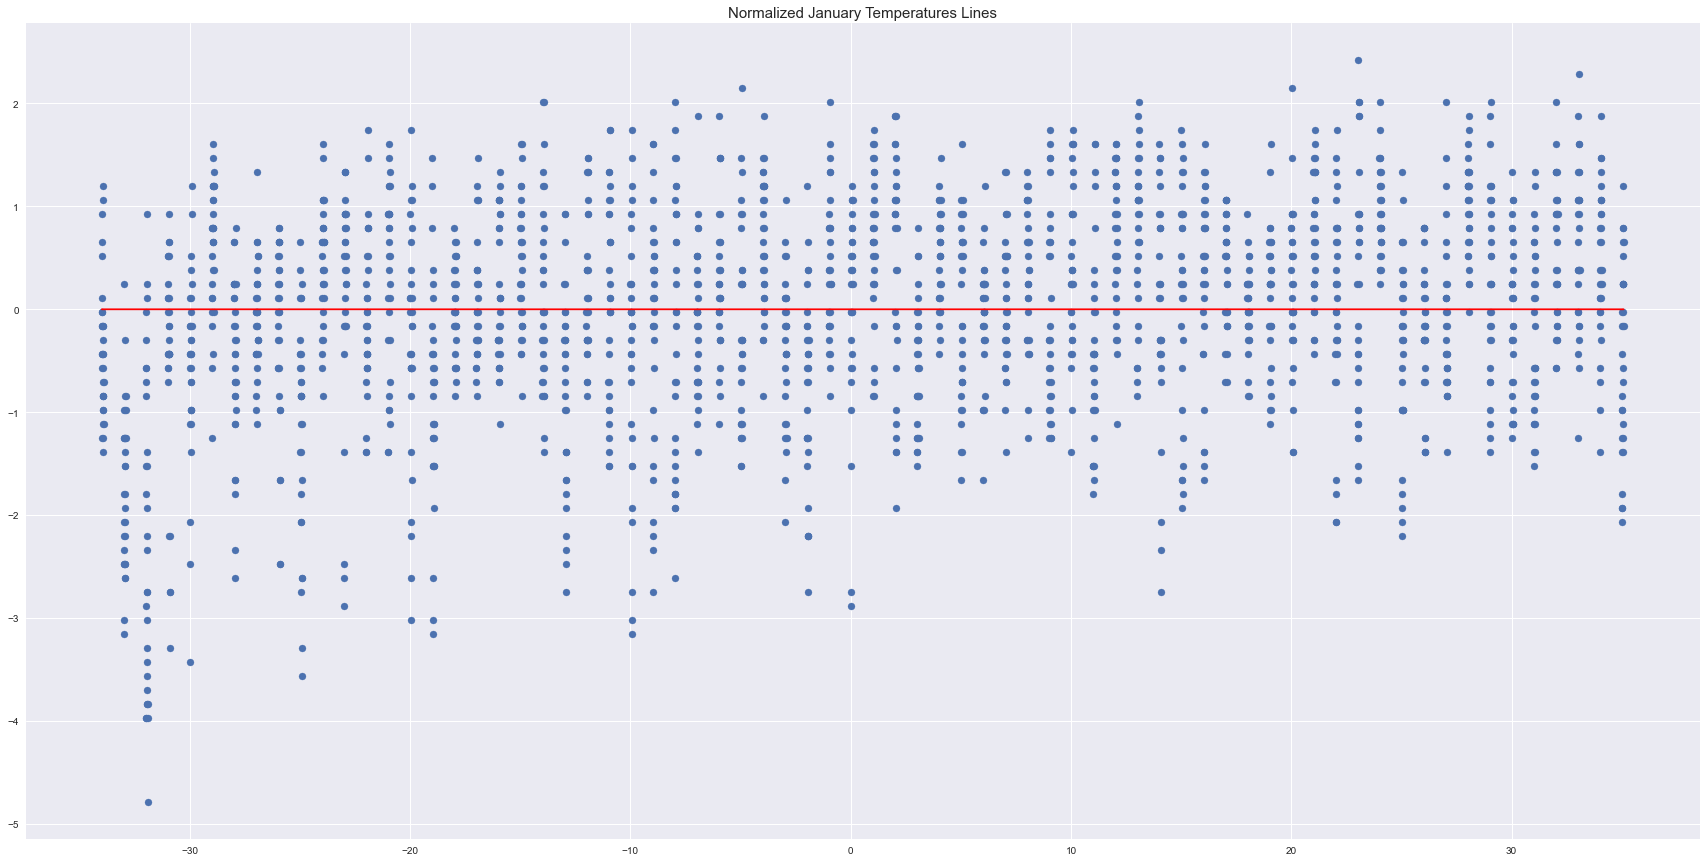

In [8]:
print(f"Model parameters before training: {model.intercept}, {model.slope}")

plt.style.use('seaborn')
fig, axs = plt.subplot_mosaic([
                                ['1'],
                                ],      
                                figsize=(30, 15))
axs["1"].set_title("Normalized January Temperatures Lines", size=15)
axs["1"].plot(data["years_since_1982"], model.predict(data["years_since_1982"]), color='red', label='Fitted line')
axs["1"].scatter(data["years_since_1982"], data["normalised_temperature"])





                                                 


### building cost function and training

In [9]:
def cost_function(actual_temperatures, estimated_temperatures):
    '''
    Calculates the difference between actual and estimated temperatures
    Returns the difference, and also returns the squared difference (the cost)

    actual_temperatures: One or more temperatures recorded in the past
    estimated_temperatures: Corresponding temperature(s) estimated by the model
    '''

    # Calculate the difference between actual temperatures and those
    # estimated by the model
    difference = estimated_temperatures - actual_temperatures

    # Convert to a single number that tells us how well the model did
    # (smaller numbers are better)
    cost = sum(difference ** 2)

    return difference, cost


# Create an optimizer
optimizer = MyOptimizer()

In [10]:
def train_one_iteration(model_inputs, true_temperatures, last_cost:float):
    '''
    Runs a single iteration of training.


    model_inputs: One or more dates to provide the model (dates)
    true_temperatues: Corresponding temperatures known to occur on those dates

    Returns:
        A Boolean, as to whether training should continue
        The cost calculated (small numbers are better)
    '''

    # === USE THE MODEL ===
    # Estimate temperatures for all data that we have
    estimated_temperatures = model.predict(model_inputs)

    # === OBJECTIVE FUNCTION ===
    # Calculate how well the model is working
    # Smaller numbers are better 
    difference, cost = cost_function(true_temperatures, estimated_temperatures)

    # Decide whether to keep training
    # We'll stop if the training is no longer improving the model effectively
    if cost >= last_cost:
        # Stop training
        return False, cost
    else:
        # === OPTIMIZER ===
        # Calculate updates to parameters
        intercept_update, slope_update = optimizer.get_parameter_updates(model_inputs, cost, difference)

        # Change the model parameters
        model.slope += slope_update
        model.intercept += intercept_update

        return True, cost



In [11]:

print(f"Model parameters before training:\t\t{model.intercept:.8f},\t{model.slope:.8f}")

continue_loop, cost = train_one_iteration(model_inputs = data["years_since_1982"],
                                                    true_temperatures = data["normalised_temperature"],
                                                    last_cost = math.inf)

print(f"Model parameters after 1 iteration of training:\t{model.intercept:.8f},\t{model.slope:.8f}")


Model parameters before training:		0.00000000,	0.00000000
Model parameters after 1 iteration of training:	0.00000000,	0.01006832


In [12]:

last_cost = math.inf
i = 0
continue_loop = True
while continue_loop:

    # Run one iteration of training
    # This will tell us whether to stop training, and also what
    # the cost was for this iteration
    continue_loop, last_cost = train_one_iteration(model_inputs = data["years_since_1982"],
                                                    true_temperatures = data["normalised_temperature"],
                                                    last_cost = last_cost)
   
    # Print the status
    if i % 400 == 0:
        print("Iteration:", i)

    i += 1

    
print("Training complete!")
print(f"Model parameters after training:\t{model.intercept:.8f},\t{model.slope:.8f}")


                              


Iteration: 0
Iteration: 400
Iteration: 800
Iteration: 1200
Iteration: 1600
Iteration: 2000
Iteration: 2400
Iteration: 2800
Iteration: 3200
Iteration: 3600
Iteration: 4000
Training complete!
Model parameters after training:	-0.00648846,	0.01193327


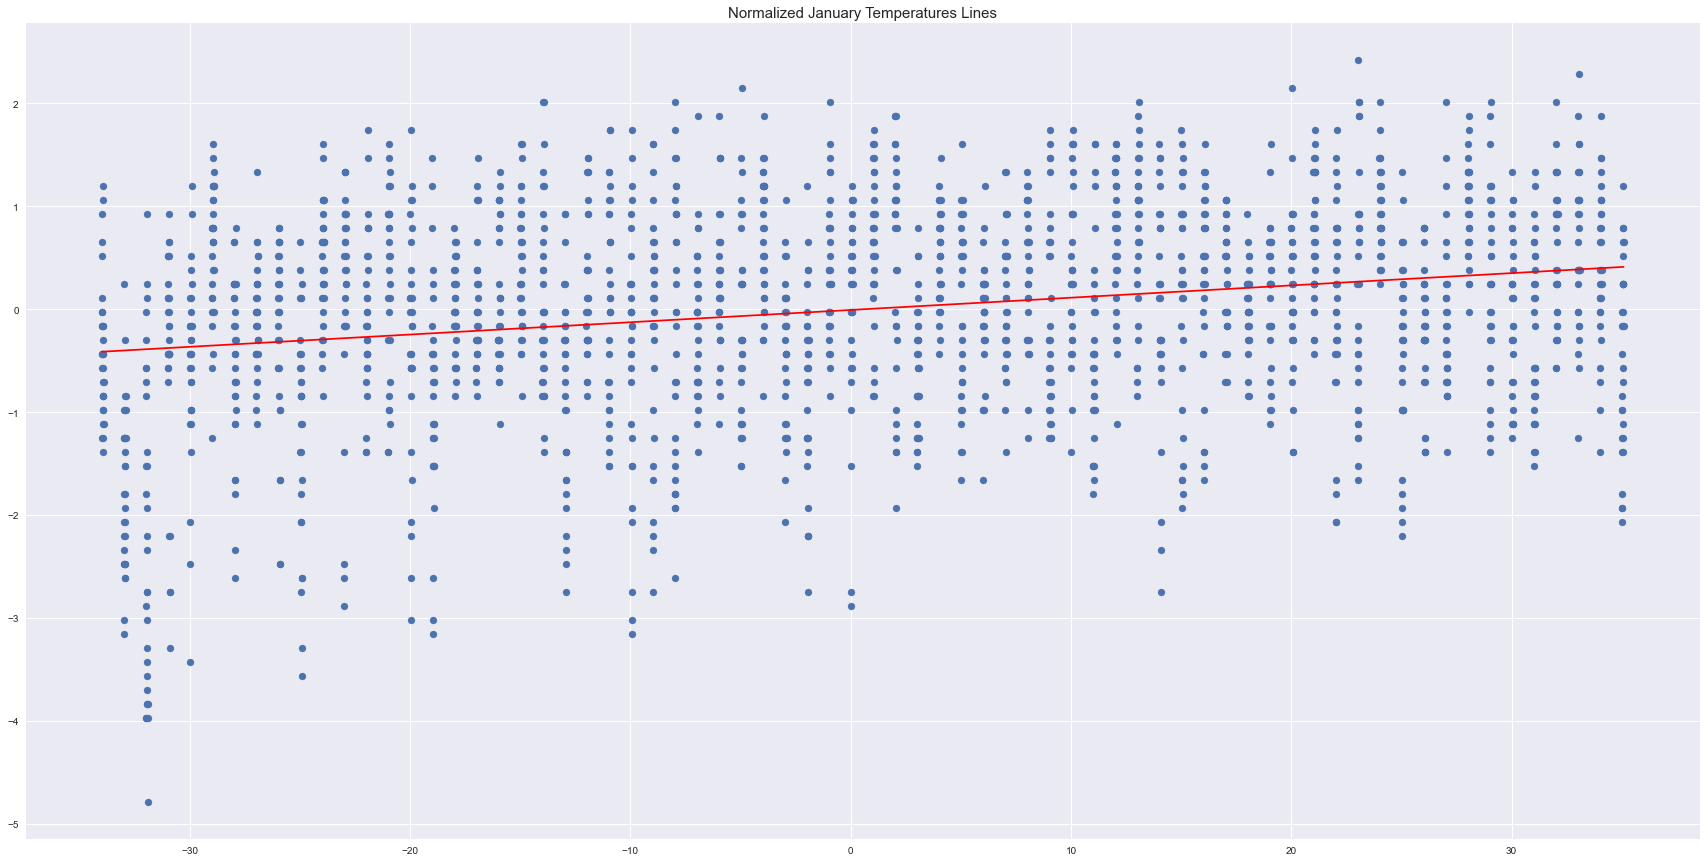

In [13]:

plt.style.use('seaborn')
fig, axs = plt.subplot_mosaic([
                                ['1'],
                                ],      
                                figsize=(30, 15))
axs["1"].set_title("Normalized January Temperatures Lines", size=15)
axs["1"].plot(data["years_since_1982"], model.predict(data["years_since_1982"]), color='red', label='Fitted line')
axs["1"].scatter(data["years_since_1982"], data["normalised_temperature"])

## another example for supervised model

In [14]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/microsoft_custom_linear_regressor.py
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv



--2024-12-17 11:17:18--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/microsoft_custom_linear_regressor.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2167 (2,1K) [text/plain]
Saving to: 'microsoft_custom_linear_regressor.py.5'

     0K ..                                                    100% 6,30M=0s

2024-12-17 11:17:18 (6,30 MB/s) - 'microsoft_custom_linear_regressor.py.5' saved [2167/2167]

--2024-12-17 11:17:18--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting t

In [15]:
# Load a file that contains our weather data
dataset = pd.read_csv('seattleWeather_1948-2017.csv', parse_dates=['date'])

# Convert the dates into numbers so we can use them in our models
# We make a year column that can contain fractions. For example,
# 1948.5 is halfway through the year 1948
dataset["year"] = [(d.year + d.timetuple().tm_yday / 365.25) for d in dataset.date]


# For the sake of this exercise, let's look at February 1 for the following years:
desired_dates = [
    datetime(1950,2,1),
    datetime(1960,2,1),
    datetime(1970,2,1),
    datetime(1980,2,1),
    datetime(1990,2,1),
    datetime(2000,2,1),
    datetime(2010,2,1),
    datetime(2017,2,1),
]

dataset = dataset[dataset.date.isin(desired_dates)].copy()

# Print the dataset
dataset

,date,amount_of_precipitation,max_temperature,min_temperature,rain,year
762,1950-02-01,0.00,27,1,False,1950.087611
4414,1960-02-01,0.15,52,44,True,1960.087611
8067,1970-02-01,0.00,50,42,False,1970.087611
11719,1980-02-01,0.37,54,36,True,1980.087611
15372,1990-02-01,0.08,45,37,True,1990.087611
19024,2000-02-01,1.34,49,41,True,2000.087611
22677,2010-02-01,0.08,49,40,True,2010.087611
25234,2017-02-01,0.00,43,29,False,2017.087611


## Comparing two cost functions

Let's compare two common cost functions: the _sum of squared differences_ (SSD) and the _sum of absolute differences_ (SAD). They both calculate the difference between each predicted value and the expected value. The distinction is simply: 

* SSD squares that difference and sums the result.
* SAD converts differences into absolute differences and then sums them.

To see these cost functions in action, we need to first implement them:

In [16]:
def sum_of_square_differences(estimate, actual):
    # Note that with NumPy, to square each value we use **
    return np.sum((estimate - actual)**2)

def sum_of_absolute_differences(estimate, actual):
    return np.sum(np.abs(estimate - actual))

In [17]:
actual_label = np.array([1, 3])
model_estimate = np.array([2, 2])

print("SSD:", sum_of_square_differences(model_estimate, actual_label))
print("SAD:", sum_of_absolute_differences(model_estimate, actual_label))

SSD: 2
SAD: 2


In [18]:
actual_label = np.array([1, 3])
model_estimate = np.array([1, 1])

print("SSD:", sum_of_square_differences(model_estimate, actual_label))
print("SAD:", sum_of_absolute_differences(model_estimate, actual_label))

SSD: 4
SAD: 2


In [19]:
# Create and fit the model
# We use a custom object that we've hidden from this notebook, because
# you don't need to understand its details. This fits a linear model
# by using a provided cost function

# Fit a model by using sum of square differences
model_ssd = MicrosoftCustomLinearRegressor().fit(X = dataset.year, 
                                             y = dataset.min_temperature, 
                                             cost_function = sum_of_square_differences)

model_sad = MicrosoftCustomLinearRegressor().fit(X = dataset.year, 
                                             y = dataset.min_temperature, 
                                             cost_function = sum_of_absolute_differences)


                                                 


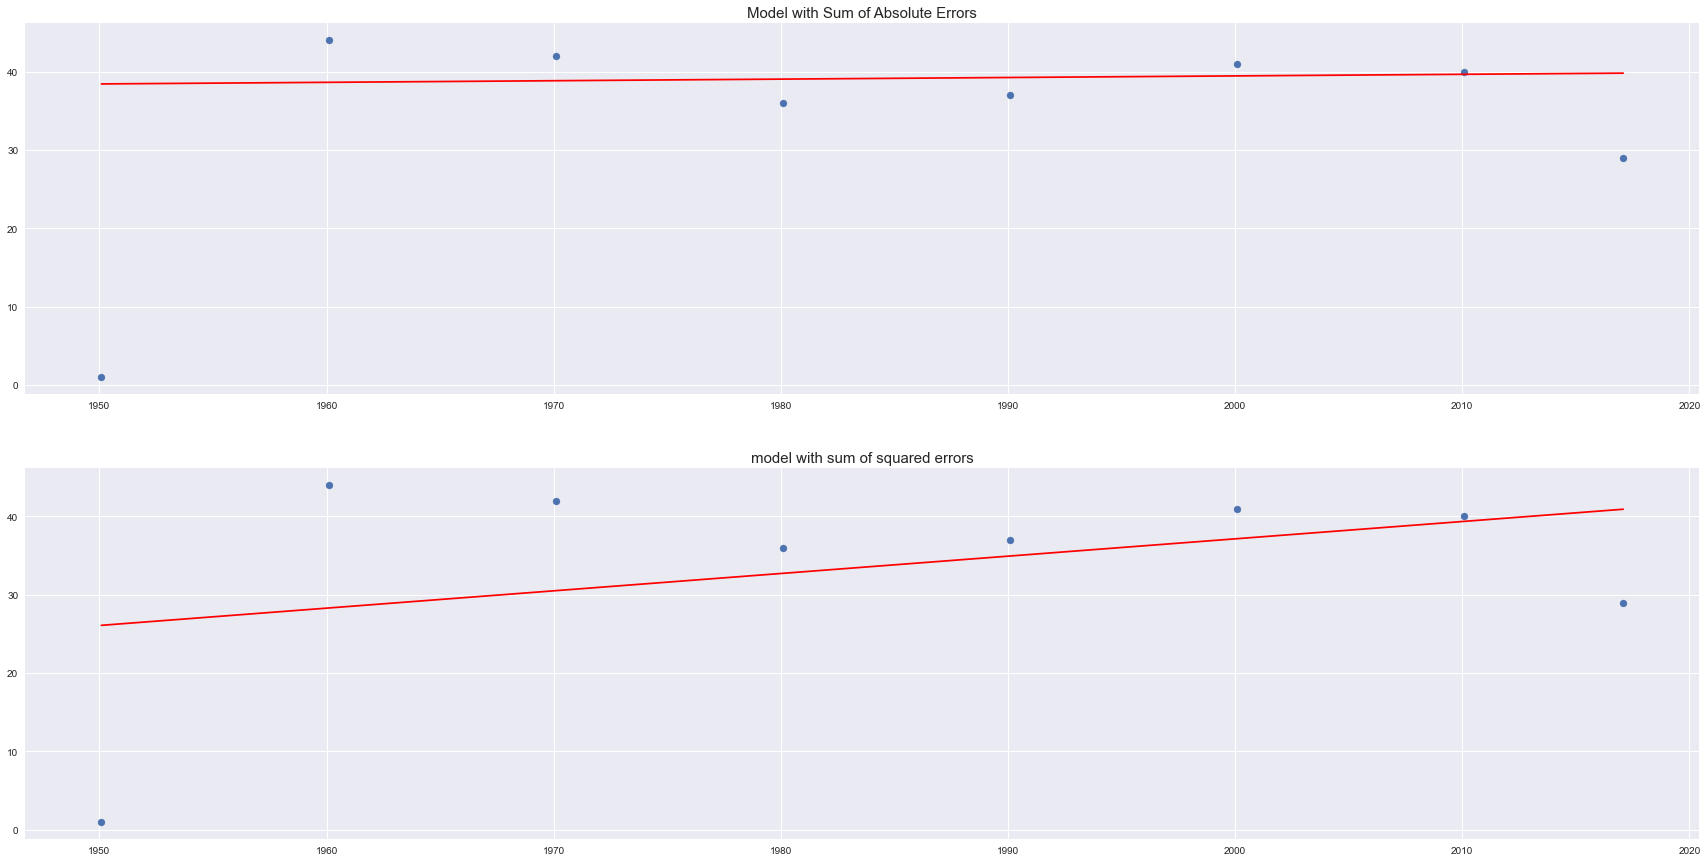

In [20]:
plt.style.use('seaborn')
fig, axs = plt.subplot_mosaic([
                                ['1'],
                                ['2'],
                                ],      
                                figsize=(30, 15))
axs["1"].set_title("Model with Sum of Absolute Errors", size=15)
axs["1"].plot(dataset["year"], model_sad.predict(dataset["year"]), 'r', label='Fitted line SAD')
axs["1"].scatter(dataset["year"], dataset["min_temperature"])

axs["2"].set_title("model with sum of squared errors", size=15)
axs["2"].plot(dataset["year"], model_ssd.predict(dataset["year"]), 'r', label='Fitted line SSD')
axs["2"].scatter(dataset["year"], dataset["min_temperature"])



# Exercise: Gradient descent

Previously, we identified trends in winter temperatures by fitting a linear regression model to weather data. Here, we'll repeat this process by focusing on the optimizer. Specifically, we'll work with batch gradient descent and explore how changing the learning rate can alter its behavior.

The model with which we'll be working is the same linear-regression model that we've used in other units. The principles we learn, however, also apply to much more complex models.

## Loading data and preparing our model

Let's load up our weather data from Seattle, filter to January temperatures, and make slight adjustments so that the dates are mathematically interpretable.

In [21]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv



--2024-12-17 11:17:19--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/seattleWeather_1948-2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 762017 (744K) [text/plain]
Saving to: 'seattleWeather_1948-2017.csv.11'

     0K .......... .......... .......... .......... ..........  6% 2,27M 0s
    50K .......... .......... .......... .......... .......... 13% 1004K 0s
   100K .......... .......... .......... .......... .......... 20% 8,07M 0s
   150K .......... .......... .......... .......... .......... 26% 10,2M 0s
   200K .......... .......... .......... .......... .......... 33% 8,36M 0s
   250K .......... .......... .......... .......... .......... 40% 4,52M 0s
   300K .......... ...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


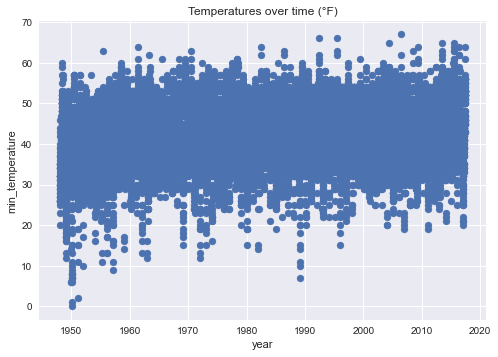

In [22]:
# Load a file that contains weather data for Seattle
data = pd.read_csv('seattleWeather_1948-2017.csv', parse_dates=['date'])

# Remove all dates after July 1 because we have to to plant onions before summer begins
data = data[[d.month < 7 for d in data.date]].copy()


# Convert the dates into numbers so we can use them in our models
# We make a year column that can contain fractions. For example,
# 1948.5 is halfway through the year 1948
data["year"] = [(d.year + d.timetuple().tm_yday / 365.25) for d in data.date]

# Let's take a quick look at our data
plt.scatter(data["year"], data["min_temperature"])

# add labels and legend
plt.xlabel("year")
plt.ylabel("min_temperature")
plt.title("Temperatures over time (°F)")
plt.legend()

In [23]:
# Perform linear regression to fit a line to our data
# NB OLS uses the sum or mean of squared differences as a cost function,
# which we're familiar with from our last exercise 
model = smf.ols(formula = "min_temperature ~ year", data = data).fit()

# Print the model
intercept = model.params[0]
slope = model.params[1]

print(f"The model is: y = {slope:0.3f} * X + {intercept:0.3f}")

The model is: y = 0.063 * X + -83.073


## Model selection

The first step is always selecting a model. Let's reuse the model that we used in previous exercises.

In [24]:
class MyModel:

    def __init__(self):
        '''
        Creates a new MyModel
        '''
        # Straight lines described by two parameters:
        # The slope is the angle of the line
        self.slope = 0
        # The intercept moves the line up or down
        self.intercept = 0

    def predict(self, date):
        '''
        Estimates the temperature from the date
        '''
        return date * self.slope + self.intercept

    def get_summary(self):
        '''
        Returns a string that summarises the model
        '''
        return f"y = m: {self.slope} * x + b: {self.intercept}"

print("Model class ready")

Model class ready


### Implementing gradient descent

To implement gradient descent, we need a method that can calculate the preceding curve's gradient. 

In [25]:
x = data.year
temperature_true = data.min_temperature

# Here, we set:
#   x to a range of potential model intercepts
#   y to a range of potential model slopes
#   z as the cost for that combination of model parameters   

# Choose a range of intercepts and slopes values
intercepts = np.linspace(-100,-70,10)
slopes = np.linspace(0.060,0.07,10)


# Set a cost function. This will be the mean of squared differences
def cost_function(temperature_estimate):
    """
    Calculates cost for a given temperature estimate
    Our cost function is the mean of squared differences (a.k.a. mean squared error)
    """
    # Note that with NumPy to square each value, we use **
    return np.mean((temperature_true - temperature_estimate) ** 2)

def predict_and_calc_cost(intercept, slope):
    '''
    Uses the model to make a prediction, then calculates the cost 
    '''

    # Predict temperature by using these model parameters
    temperature_estimate = x * slope + intercept

    # Calculate cost
    return cost_function(temperature_estimate)

def calculate_gradient(temperature_estimate):
    """
    This calculates the gradient for a linear regession 
    by using the Mean Squared Error cost function
    """

    # The partial derivatives of MSE are as follows
    # You don't need to be able to do this just yet, but
    # it's important to note that these give you the two gradients
    # that we need to train our model
    error = temperature_estimate - temperature_true
    grad_intercept = np.mean(error) * 2
    grad_slope = (x * error).mean() * 2

    return grad_intercept, grad_slope


## gradient descent limited to slope

In [31]:
def gradient_descent(learning_rate, number_of_iterations):
    """
    Performs gradient descent for a one-variable function. 

    learning_rate: Larger numbers follow the gradient more aggressively
    number_of_iterations: The maximum number of iterations to perform
    """

    # Our starting guess is y = 0 * x - 83
    # We're going to start with the correct intercept so that 
    # only the line's slope is estimated. This is just to keep
    # things simple for this exercise
    model = MyModel()
    model.intercept = -83
    model.slope = 0

    for i in range(number_of_iterations):
        # Calculate the predicted values
        predicted_temperature = model.predict(x)

        # == OPTIMIZER ===
        # Calculate the gradient
        _, grad_slope = calculate_gradient(predicted_temperature)
        # Update the estimation of the line
        model.slope -= learning_rate * grad_slope

        # Print the current estimation and cost every 100 iterations
        if (i % 100 == 0):
            estimate = model.predict(x)
            cost = cost_function(estimate)
            print("Next estimate:", model.get_summary(), f"Cost: {cost}")

    # Print the final model
    print(f"Final estimate:", model.get_summary())

# Run gradient descent
gradient_descent(learning_rate=1E-9, number_of_iterations=5000)

Next estimate: y = m: 0.0004946403321335815 * x + b: -83 Cost: 15374.064817888926
Next estimate: y = m: 0.034564263954523125 * x + b: -83 Cost: 3218.050332426434
Next estimate: y = m: 0.050035120236006536 * x + b: -83 Cost: 711.4491469584532
Next estimate: y = m: 0.057060363506525755 * x + b: -83 Cost: 194.58159053167708
Next estimate: y = m: 0.060250493523378544 * x + b: -83 Cost: 88.00218235322349
Next estimate: y = m: 0.06169911660055105 * x + b: -83 Cost: 66.02523660294695
Next estimate: y = m: 0.06235692954504888 * x + b: -83 Cost: 61.4935343467107
Next estimate: y = m: 0.0626556393176375 * x + b: -83 Cost: 60.559085785362484
Next estimate: y = m: 0.06279128202425543 * x + b: -83 Cost: 60.36640010911254
Next estimate: y = m: 0.06285287674109104 * x + b: -83 Cost: 60.32666783130979
Next estimate: y = m: 0.06288084661309272 * x + b: -83 Cost: 60.31847493430717
Next estimate: y = m: 0.06289354760077441 * x + b: -83 Cost: 60.316785538052855
Next estimate: y = m: 0.06289931505970599 * 